# Классификация грибов

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm, trange

from sklearn.metrics import classification_report, confusion_matrix

import torch as t
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, random_split
from torchvision import transforms, datasets, models

In [72]:
from PIL import ImageFile

# Во избежание ошибок
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [20]:
!pip install kagglehub

In [5]:
import kagglehub

# Скачиваем последнюю версию
path = kagglehub.dataset_download("maysee/mushrooms-classification-common-genuss-images")

print("Path to dataset files:", path)

100%|██████████| 1.85G/1.85G [00:32<00:00, 62.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/maysee/mushrooms-classification-common-genuss-images/versions/1


In [73]:
# Создаем трансформер для изображений
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Импортируем данные
data = datasets.ImageFolder(root=path + '/Mushrooms', transform=transform)

In [74]:
# Разделяем выборку на тренировочную и тестовую
train_size = int(0.85 * len(data))
test_size = len(data) - train_size

train_data, test_data = random_split(data, (train_size, test_size))

In [75]:
# Фиксируем кол-во классов
num_classes = np.unique(data.targets).size

In [114]:
def train(model, gadget, train_loader, test_loader, criterion, optimizer,
          num_epochs, scheduler = None, train_losses_list = None, test_losses_list = None):
    """Функция обучения нейросети"""
    if train_losses_list is None and test_losses_list is None:
        train_losses_list = []
        test_losses_list = []

    for _ in trange(num_epochs):
        model.train()

        desc = round(train_losses_list[-1], 4) if len(train_losses_list) > 0 else np.inf
        for batch in tqdm(train_loader, desc=f'Последний trainloss={desc}'):
            X_batch = batch[0].to(gadget)
            y_batch = batch[1].to(gadget)

            optimizer.zero_grad()

            logit = model(X_batch)
            loss = criterion(logit, y_batch)

            loss.backward()
            optimizer.step()

            train_losses_list.append(loss.item())

        if scheduler is not None:
            scheduler.step()

        model.eval()
        with t.no_grad():
            desc = round(test_losses_list[-1], 4) if len(test_losses_list) > 0 else np.inf
            for batch in tqdm(test_loader, desc=f'Последний testloss={desc}'):
                X_batch = batch[0].to(gadget)
                y_batch = batch[1].to(gadget)

                loss = criterion(model(X_batch), y_batch)
                test_losses_list.append(loss.item())

    return train_losses_list, test_losses_list

In [116]:
def plot_losses(losses: list, n_part: int, label: str):
    """Сворачиваем потери до n_part точек и отрисовываем"""
    compacted_losses = [np.mean(losses[i * len(losses) // n_part: (i + 1) * len(losses) // n_part]) for i in range(n_part)]
    plt.plot(compacted_losses, label=label)

def plot_confusion_matrix(y_true: np.ndarray, y_pred: np.ndarray, classes: dict):
    """Рисуем heatmap для матрицы несоответствий"""
    conf_mat = confusion_matrix(y_true, y_pred)

    sns.heatmap(conf_mat, annot=True, xticklabels=classes, yticklabels=classes)

### Дообучение модели VGG16BN.

In [117]:
# Импортируем предобученную модель
vgg_model = models.vgg16_bn(pretrained=True)

# Задаем кол-во замороженных слоев и замораживаем их
layers_amount = len(list(vgg_model.parameters()))
freeze_layers = layers_amount - 6

grad_requirement = np.array([True] * layers_amount)
grad_requirement[:freeze_layers] = False

idx = 0
for param in vgg_model.parameters():
    param.requires_grad = bool(grad_requirement[idx])
    idx += 1

# Заменяем последний слой
vgg_model.classifier[-1] = nn.Linear(in_features=vgg_model.classifier[-1].in_features, out_features=num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [1]:
# Используем по возможности CUDA
device = 'cuda' if t.cuda.is_available() else 'cpu'
vgg_model.to(device)

# Задаем гиперпараметры
learning_rate = 0.00003
batch_size = 64
step_size = 3
gamma = 0.1
epochs = 7

# Создаем DataLoader'ы
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_data, batch_size=batch_size, num_workers=2)

# Фиксируем функцию потерь и оптимизатор
loss_function = nn.CrossEntropyLoss()

params = filter(lambda p: p.requires_grad, vgg_model.parameters())
optim = t.optim.Adam(params, lr=learning_rate)
sched = t.optim.lr_scheduler.StepLR(optim, step_size=step_size, gamma=gamma)

NameError: name 't' is not defined

In [119]:
# Обучение модели
train_losses, test_losses = train(vgg_model, device, train_dataloader, test_dataloader, loss_function, optim, epochs, sched)

  0%|          | 0/7 [00:00<?, ?it/s]

Последний trainloss=inf:   0%|          | 0/90 [00:00<?, ?it/s]

Последний testloss=inf:   0%|          | 0/16 [00:00<?, ?it/s]

Последний trainloss=1.365:   0%|          | 0/90 [00:00<?, ?it/s]

Последний testloss=1.1982:   0%|          | 0/16 [00:00<?, ?it/s]

Последний trainloss=0.613:   0%|          | 0/90 [00:00<?, ?it/s]

Последний testloss=1.0334:   0%|          | 0/16 [00:00<?, ?it/s]

Последний trainloss=0.469:   0%|          | 0/90 [00:00<?, ?it/s]

Последний testloss=0.9604:   0%|          | 0/16 [00:00<?, ?it/s]

Последний trainloss=0.3943:   0%|          | 0/90 [00:00<?, ?it/s]

Последний testloss=0.8878:   0%|          | 0/16 [00:00<?, ?it/s]

Последний trainloss=0.3389:   0%|          | 0/90 [00:00<?, ?it/s]

Последний testloss=0.8717:   0%|          | 0/16 [00:00<?, ?it/s]

Последний trainloss=0.1897:   0%|          | 0/90 [00:00<?, ?it/s]

Последний testloss=0.8673:   0%|          | 0/16 [00:00<?, ?it/s]

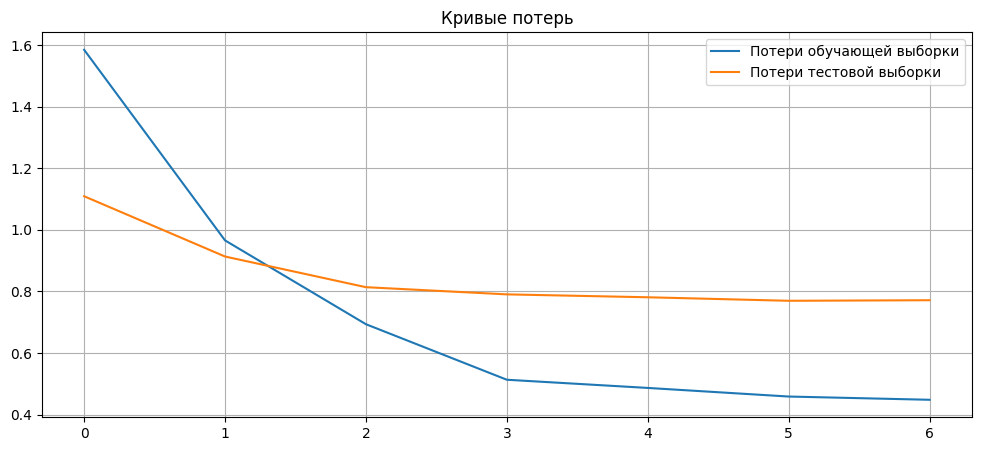

In [120]:
# Нарисуем графики потерь
plt.figure(figsize=(12, 5))

plt.title('Кривые потерь')

plot_losses(train_losses, n_part=epochs, label='Потери обучающей выборки')
plot_losses(test_losses, n_part=epochs, label='Потери тестовой выборки')

plt.grid()
plt.legend();

In [121]:
# Заполняем реальные и предсказанные тестовые значения
y_test = []
y_pred = []

vgg_model.eval()
with t.no_grad():
    for Xt_batch, yt_batch in tqdm(test_dataloader):
        y_test.append(yt_batch.cpu())
        y_pred.append(t.argmax(vgg_model(Xt_batch.to(device)), dim=-1).cpu())

y_test = np.hstack(y_test)
y_pred = np.hstack(y_pred)

  0%|          | 0/16 [00:00<?, ?it/s]

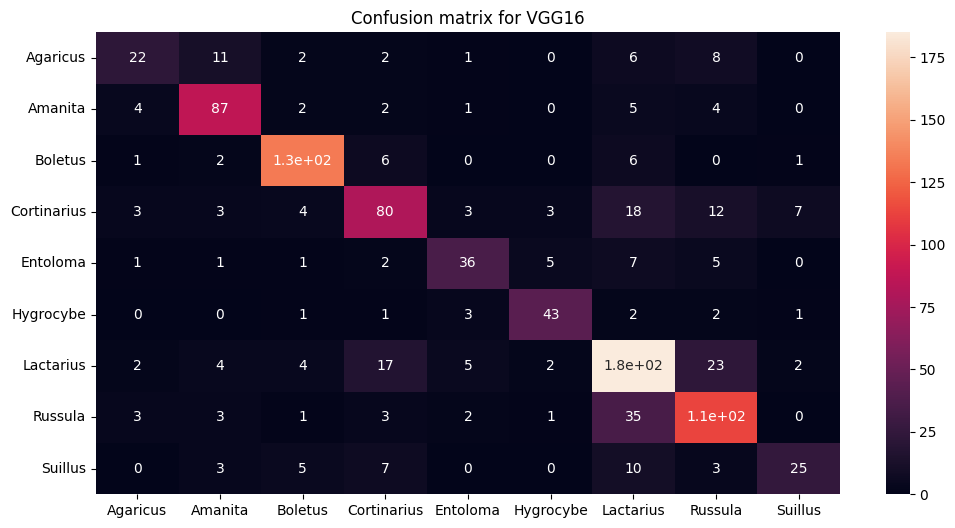

In [122]:
# Матрица несоответствий
plt.figure(figsize=(12, 6))

plt.title('Confusion matrix for VGG16')
plot_confusion_matrix(y_test, y_pred, classes=data.class_to_idx)

In [107]:
# Показатели метрик
print(classification_report(y_test, y_pred, target_names=data.class_to_idx))

              precision    recall  f1-score   support

    Agaricus       0.66      0.44      0.53        52
     Amanita       0.77      0.85      0.81       105
     Boletus       0.89      0.91      0.90       149
 Cortinarius       0.69      0.65      0.67       133
    Entoloma       0.75      0.69      0.72        58
   Hygrocybe       0.87      0.85      0.86        53
   Lactarius       0.75      0.77      0.76       244
     Russula       0.68      0.75      0.71       161
     Suillus       0.64      0.57      0.60        53

    accuracy                           0.75      1008
   macro avg       0.74      0.72      0.73      1008
weighted avg       0.75      0.75      0.75      1008



### Дообучение модели ResNet34.

In [137]:
# Импортируем предобученную модель
resnet_model = models.resnet34(pretrained=True)

# Задаем кол-во замороженных слоев и замораживаем их
layers_amount = len(list(resnet_model.parameters()))
freeze_layers = layers_amount - 1

grad_requirement = np.array([True] * layers_amount)
grad_requirement[:freeze_layers] = False

idx = 0
for param in resnet_model.parameters():
    param.requires_grad = bool(grad_requirement[idx])
    idx += 1

# Заменяем последний слой
resnet_model.fc = nn.Linear(in_features=resnet_model.fc.in_features, out_features=num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [138]:
# Используем по возможности CUDA
resnet_model.to(device)

# Задаем гиперпараметры
learning_rate = 0.001
batch_size = 64
step_size = 5
gamma = 0.1
epochs = 10

# Создаем DataLoader'ы
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_data, batch_size=batch_size, num_workers=2)

# Фиксируем функцию потерь и оптимизатор
loss_function = nn.CrossEntropyLoss()

params = filter(lambda p: p.requires_grad, resnet_model.parameters())
optim = t.optim.Adam(params, lr=learning_rate)
sched = t.optim.lr_scheduler.StepLR(optim, step_size=step_size, gamma=gamma)

In [139]:
# Обучение модели
train_losses, test_losses = train(resnet_model, device, train_dataloader, test_dataloader, loss_function, optim, epochs, sched)

  0%|          | 0/10 [00:00<?, ?it/s]

Последний trainloss=inf:   0%|          | 0/90 [00:00<?, ?it/s]

Последний testloss=inf:   0%|          | 0/16 [00:00<?, ?it/s]

Последний trainloss=1.1134:   0%|          | 0/90 [00:00<?, ?it/s]

Последний testloss=1.1941:   0%|          | 0/16 [00:00<?, ?it/s]

Последний trainloss=0.6799:   0%|          | 0/90 [00:00<?, ?it/s]

Последний testloss=1.0388:   0%|          | 0/16 [00:00<?, ?it/s]

Последний trainloss=1.3851:   0%|          | 0/90 [00:00<?, ?it/s]

Последний testloss=0.8664:   0%|          | 0/16 [00:00<?, ?it/s]

Последний trainloss=0.7509:   0%|          | 0/90 [00:00<?, ?it/s]

Последний testloss=0.8308:   0%|          | 0/16 [00:00<?, ?it/s]

Последний trainloss=0.9541:   0%|          | 0/90 [00:00<?, ?it/s]

Последний testloss=0.7965:   0%|          | 0/16 [00:00<?, ?it/s]

Последний trainloss=0.8849:   0%|          | 0/90 [00:00<?, ?it/s]

Последний testloss=0.7636:   0%|          | 0/16 [00:00<?, ?it/s]

Последний trainloss=0.5452:   0%|          | 0/90 [00:00<?, ?it/s]

Последний testloss=0.7482:   0%|          | 0/16 [00:00<?, ?it/s]

Последний trainloss=0.786:   0%|          | 0/90 [00:00<?, ?it/s]

Последний testloss=0.7424:   0%|          | 0/16 [00:00<?, ?it/s]

Последний trainloss=0.7002:   0%|          | 0/90 [00:00<?, ?it/s]

Последний testloss=0.7366:   0%|          | 0/16 [00:00<?, ?it/s]

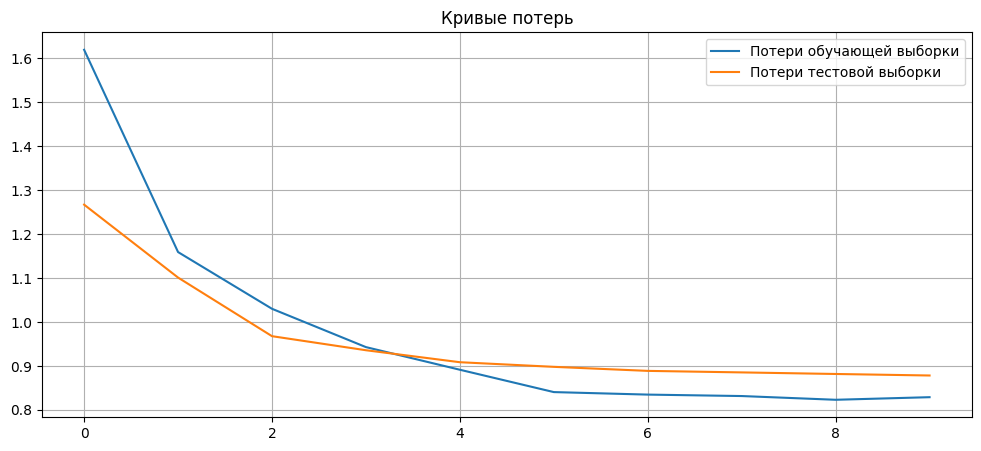

In [140]:
# Нарисуем графики потерь
plt.figure(figsize=(12, 5))

plt.title('Кривые потерь')

plot_losses(train_losses, n_part=epochs, label='Потери обучающей выборки')
plot_losses(test_losses, n_part=epochs, label='Потери тестовой выборки')

plt.grid()
plt.legend();

In [173]:
# Заполняем реальные и предсказанные тестовые значения
y_test = []
y_pred = []

resnet_model.eval()
with t.no_grad():
    for Xt_batch, yt_batch in tqdm(test_dataloader):
        y_test.append(yt_batch.cpu())
        y_pred.append(t.argmax(resnet_model(Xt_batch.to(device)), dim=-1).cpu())

y_test = np.hstack(y_test)
y_pred = np.hstack(y_pred)

  0%|          | 0/16 [00:00<?, ?it/s]

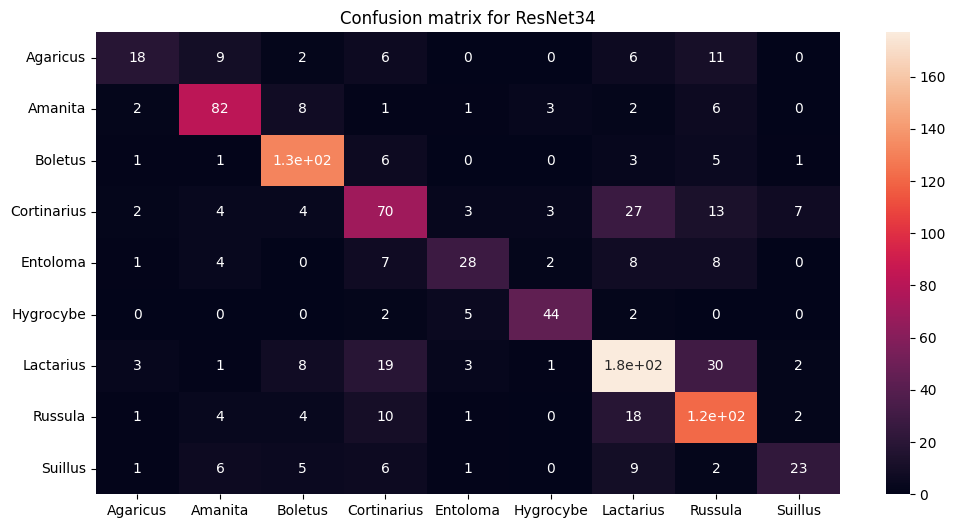

In [174]:
# Матрица несоответствий
plt.figure(figsize=(12, 6))

plt.title('Confusion matrix for ResNet34')
plot_confusion_matrix(y_test, y_pred, classes=data.class_to_idx)

In [175]:
# Показатели метрик
print(classification_report(y_test, y_pred, target_names=data.class_to_idx))

              precision    recall  f1-score   support

    Agaricus       0.62      0.35      0.44        52
     Amanita       0.74      0.78      0.76       105
     Boletus       0.81      0.89      0.85       149
 Cortinarius       0.55      0.53      0.54       133
    Entoloma       0.67      0.48      0.56        58
   Hygrocybe       0.83      0.83      0.83        53
   Lactarius       0.70      0.73      0.71       244
     Russula       0.62      0.75      0.68       161
     Suillus       0.66      0.43      0.52        53

    accuracy                           0.69      1008
   macro avg       0.69      0.64      0.65      1008
weighted avg       0.69      0.69      0.68      1008



### Дообучение модели GoogLeNet.

In [165]:
# Импортируем предобученную модель
googleNet_model = models.googlenet(pretrained=True)

# Задаем кол-во замороженных слоев и замораживаем их
layers_amount = len(list(googleNet_model.parameters()))
freeze_layers = layers_amount - 1

grad_requirement = np.array([True] * layers_amount)
grad_requirement[:freeze_layers] = False

idx = 0
for param in resnet_model.parameters():
    param.requires_grad = bool(grad_requirement[idx])
    idx += 1

# Заменяем последний слой
googleNet_model.fc = nn.Linear(in_features=googleNet_model.fc.in_features, out_features=num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [166]:
# Используем по возможности CUDA
googleNet_model.to(device)

# Задаем гиперпараметры
learning_rate = 0.0001
batch_size = 64
epochs = 5

# Создаем DataLoader'ы
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_data, batch_size=batch_size, num_workers=2)

# Фиксируем функцию потерь и оптимизатор
loss_function = nn.CrossEntropyLoss()

params = filter(lambda p: p.requires_grad, googleNet_model.parameters())
optim = t.optim.Adam(params, lr=learning_rate)

In [167]:
# Обучение модели
train_losses, test_losses = train(googleNet_model, device, train_dataloader, test_dataloader, loss_function, optim, epochs)

  0%|          | 0/5 [00:00<?, ?it/s]

Последний trainloss=inf:   0%|          | 0/90 [00:00<?, ?it/s]

Последний testloss=inf:   0%|          | 0/16 [00:00<?, ?it/s]

Последний trainloss=1.3057:   0%|          | 0/90 [00:00<?, ?it/s]

Последний testloss=1.0631:   0%|          | 0/16 [00:00<?, ?it/s]

Последний trainloss=0.7386:   0%|          | 0/90 [00:00<?, ?it/s]

Последний testloss=0.6693:   0%|          | 0/16 [00:00<?, ?it/s]

Последний trainloss=0.736:   0%|          | 0/90 [00:00<?, ?it/s]

Последний testloss=0.4859:   0%|          | 0/16 [00:00<?, ?it/s]

Последний trainloss=0.3483:   0%|          | 0/90 [00:00<?, ?it/s]

Последний testloss=0.4186:   0%|          | 0/16 [00:00<?, ?it/s]

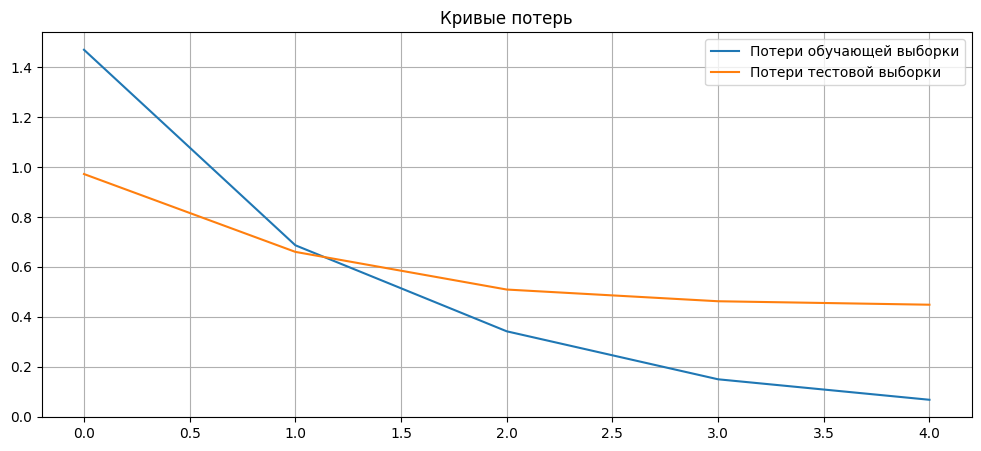

In [168]:
# Нарисуем графики потерь
plt.figure(figsize=(12, 5))

plt.title('Кривые потерь')

plot_losses(train_losses, n_part=epochs, label='Потери обучающей выборки')
plot_losses(test_losses, n_part=epochs, label='Потери тестовой выборки')

plt.grid()
plt.legend();

In [176]:
# Заполняем реальные и предсказанные тестовые значения
y_test = []
y_pred = []

googleNet_model.eval()
with t.no_grad():
    for Xt_batch, yt_batch in tqdm(test_dataloader):
        y_test.append(yt_batch.cpu())
        y_pred.append(t.argmax(googleNet_model(Xt_batch.to(device)), dim=-1).cpu())

y_test = np.hstack(y_test)
y_pred = np.hstack(y_pred)

  0%|          | 0/16 [00:00<?, ?it/s]

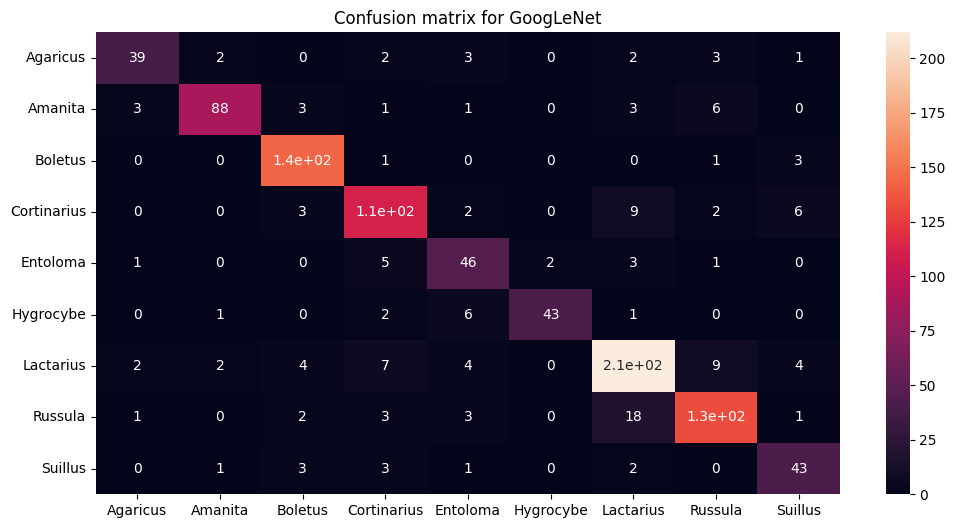

In [177]:
# Матрица несоответствий
plt.figure(figsize=(12, 6))

plt.title('Confusion matrix for GoogLeNet')
plot_confusion_matrix(y_test, y_pred, classes=data.class_to_idx)

In [178]:
# Показатели метрик
print(classification_report(y_test, y_pred, target_names=data.class_to_idx))

              precision    recall  f1-score   support

    Agaricus       0.85      0.75      0.80        52
     Amanita       0.94      0.84      0.88       105
     Boletus       0.91      0.97      0.94       149
 Cortinarius       0.82      0.83      0.83       133
    Entoloma       0.70      0.79      0.74        58
   Hygrocybe       0.96      0.81      0.88        53
   Lactarius       0.85      0.87      0.86       244
     Russula       0.86      0.83      0.84       161
     Suillus       0.74      0.81      0.77        53

    accuracy                           0.85      1008
   macro avg       0.85      0.83      0.84      1008
weighted avg       0.86      0.85      0.85      1008



Итоговые метрики:
- `VGG16BN`ㅤ-ㅤaccuracy=0.75,ㅤㅤf1-score(macro)=0.73
- `ResNet34`ㅤ-ㅤaccuracy=0.69,ㅤㅤf1-score(macro)=0.65
- `GoogLeNet`ㅤ-ㅤaccuracy=0.85,ㅤㅤf1-score(macro)=0.84
